In [1]:
import csv
import re
import os 
import sys
import pickle
import pandas as pd
import gensim
from gensim import corpora
from collections import Counter

def clean_data(df):
    df = [re.sub(r'\b[A-Z]+(?:\s+[A-Z]+)*\b', '', ls) for ls in df] # remove words that are all upper case - so names 
    df = [re.sub(r'\\\\n|\\\\t|\'s', '', ls) for ls in df] # remove lien breaks, tab breaks, and possessive "s"
    df = [re.sub(r'[^\w\s]|_', '', ls) for ls in df] # remove punctuation and underscore
    df = [re.sub(r'\d{1, 3}', '', ls) for ls in df] # remove digits that are a minimum of 1 and a maximum of 3
    df = [re.sub(r'\b\w{1,3}\b', '', ls) for ls in df] # test
    df = [re.sub(r'\w*\d\w*', '', ls) for ls in df] # remove character strings that contain a digit
            
    df = [word.lower() for word in df]
    
    df = [ls.split() for ls in df]

    return df

def import_stopwords(): # read stop words as list of strings
    with open(path + 'topic-modeling/stopwords.csv') as f:
        stopwords = f.read().splitlines()[1:]
            
    stopwords = re.compile('|'.join(stopwords))

    return stopwords

In [33]:
working_dir = '/users/sbuongiorno/'
n_topics = 100

In [3]:
fname = '/scratch/group/pract-txt-mine/sbuongiorno/hansard_decades/hansard_1800.csv'

with open(fname, newline='') as f:
    reader = csv.reader(f)
    text = list(reader)[1:]
    text = list(map(str, text))

text[:2]

["['S1V0001P0_0', 'moved that Lord Walsingham be appointed chairman of the committee of privileges for the present session.']",
 '[\'S1V0001P0_11\', "The subject, in his contemplation, was such as not only that house, but many thousands of his Majesty\'s subjects must regard with the utmost concern."]']

In [4]:
# stopwords = topic_model.import_stopwords()

In [5]:
data = clean_data(data)

data[:2]

[['moved',
  'that',
  'lord',
  'walsingham',
  'appointed',
  'chairman',
  'committee',
  'privileges',
  'present',
  'session'],
 ['subject',
  'contemplation',
  'such',
  'only',
  'that',
  'house',
  'many',
  'thousands',
  'majesty',
  'subjects',
  'must',
  'regard',
  'with',
  'utmost',
  'concern']]

In [6]:
dictionary = corpora.Dictionary(data)

dictionary

In [7]:
corpus = [dictionary.doc2bow(text) for text in data]

corpus[:2]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1)],
 [(8, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1)]]

In [8]:
%%time

lda_model = gensim.models.LdaMulticore(corpus, num_topics = n_topics, id2word=dictionary, workers = 4, passes=15)

CPU times: user 59min 45s, sys: 13min 56s, total: 1h 13min 41s
Wall time: 1h 30min 34s


## Saving

In [21]:
working_folder = working_dir + 'lda_topic_model_test/'

if not os.path.exists(export_folder):
    os.mkdir(export_folder)

In [22]:
pickle.dump(corpus, open(working_folder + 'corpus.pkl', 'wb'))
dictionary.save(working_folder + 'dictionary.gensim')
lda_model.save(working_folder + 'model.gensim')

## Loading

In [23]:
corpus = pickle.load(open(working_folder +  'corpus.pkl', 'rb'))
dictionary = gensim.corpora.Dictionary.load(working_folder + 'dictionary.gensim')
lda_model = gensim.models.ldamodel.LdaModel.load(working_folder + 'model.gensim')

In [41]:
lda_model.show_topics(formatted=False, num_topics = 5)

[(79,
  [('members', 0.21864453),
   ('irish', 0.13190669),
   ('future', 0.05683022),
   ('national', 0.04387624),
   ('were', 0.039752763),
   ('past', 0.027603608),
   ('votes', 0.026848089),
   ('committees', 0.022873057),
   ('boroughs', 0.02233289),
   ('whereas', 0.017042218)]),
 (75,
  [('state', 0.20000722),
   ('secretary', 0.13039073),
   ('home', 0.05450194),
   ('department', 0.04757935),
   ('foreign', 0.04629696),
   ('school', 0.037353233),
   ('affairs', 0.03526736),
   ('under', 0.031279884),
   ('head', 0.031023173),
   ('protection', 0.022990663)]),
 (59,
  [('occasion', 0.10610575),
   ('former', 0.08252257),
   ('together', 0.05517718),
   ('latter', 0.04270537),
   ('from', 0.042394407),
   ('advice', 0.033531338),
   ('times', 0.031144079),
   ('procedure', 0.027539518),
   ('induced', 0.02468544),
   ('confess', 0.021871269)]),
 (51,
  [('schools', 0.094272494),
   ('necessity', 0.0703584),
   ('holding', 0.04122999),
   ('that', 0.038959187),
   ('justified', 

In [48]:
topics = lda_model.show_topics(formatted=False, num_topics = 30)
            
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)
            
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
df.to_csv(working_folder + 'topics_' + str(n_topics) + '.csv')

IndexError: list index out of range

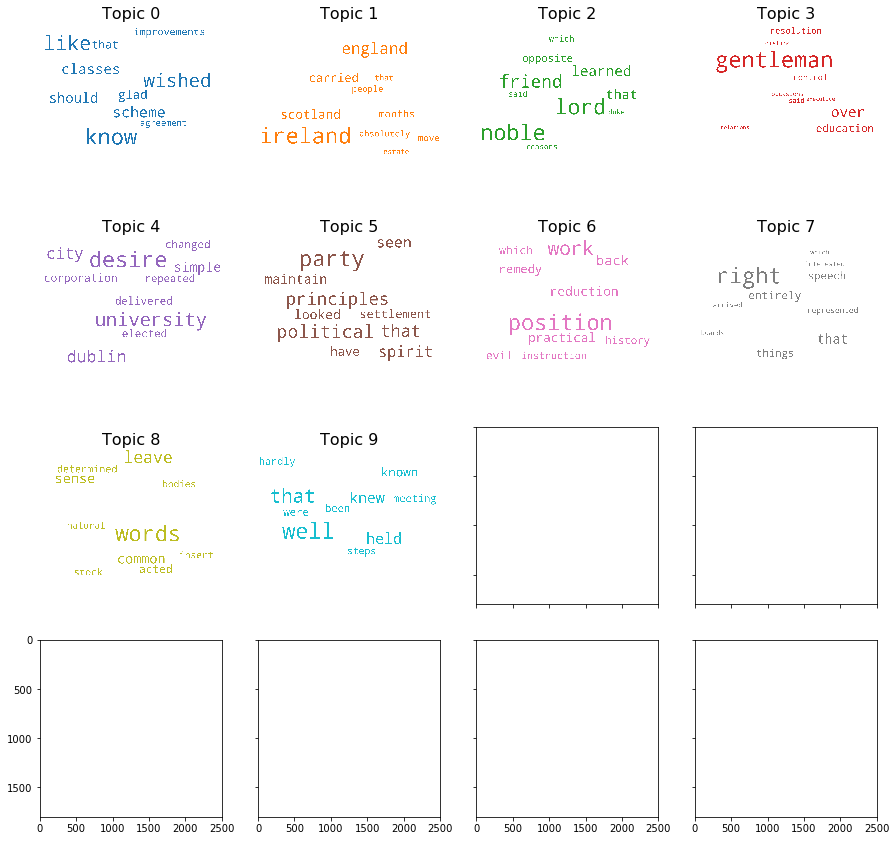

In [49]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size = 300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict = dict(size = 16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [31]:
import pyLDAvis.gensim_models
from matplotlib import pyplot as plt

start = -9
stop = 0

for t in range(0,3):
    start = start + 9
    stop = stop + 8

    fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=500)

    for i, ax in enumerate(axes.flatten()):
        i = i + start 

        #ax.set_facecolor('white')

        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :],  width=0.5, alpha=0.3, label='Word Count') #color=cols[i],
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :],  width=0.2, label='Weights') # color=cols[i],
        ax.set_ylabel('Word Count')#, color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), fontsize=16) # color=cols[i], 
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    #plt.show()

    viz_export_folder = dir + '/' + 'lda_topic_model_visualizations_' + target_folder + '/'

    if not os.path.exists(viz_export_folder):
        os.mkdir(viz_export_folder)

    plt.savefig(viz_export_folder + target_folder + '_topics_' + str(start) + '-' + str(stop) + '.jpg')
    plt.close(fig) 

ModuleNotFoundError: No module named 'pyLDAvis'

In [32]:
!pip install --user pyLDAvis

  Using cached https://files.pythonhosted.org/packages/03/a5/15a0da6b0150b8b68610cc78af80364a80a9a4c8b6dd5ee549b8989d4b60/pyLDAvis-3.3.1.tar.gz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
ERROR: Could not find a version that satisfies the requirement numpy>=1.20.0 (from pyLDAvis) (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0rc1, 1.16.0rc2, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0rc1, 1.17.0rc2, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0rc1, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4,